In [2]:
import sys, os
# sys.path.insert(0, '/content/drive/MyDrive/CloudsDL/BigEarthNet_exe_data/bigearthnet-models-tf-master')
# from BigEarthNet import BigEarthNet

import numpy as np
import pandas as pd
import re

# import tensorflow.compat.v1 as tf
import subprocess, time, os
import argparse
import json
import glob
import importlib
from osgeo import gdal, osr
gdal.UseExceptions()
from concurrent.futures import ThreadPoolExecutor
import copy
from pathlib import Path
import geopandas as gpd
import shapely
from pprint import pprint
from PIL import Image

import cv2
from tqdm import tqdm
from skimage.util.shape import view_as_windows

import tensorflow as tf
from tensorflow import keras
import pandas as pd

In [3]:
pwd

'/home/users/pete_nut/sentinel_industry'

In [33]:
# tiles = pd.read_csv('E://Users//sentinel_industry//deploy/but_nanjing', index_col=0)

In [34]:
scene_ids = tiles.index.to_numpy()

In [3]:
scene_ids=['S2B_'+l[:14]+'_0_L2A' for l in fofos]

In [4]:
# scene_ids = nl#['S2A_35VLF_20180510_0_L2A', 'S2B_35VLF_20220524_0_L2A']

output_layers = '/gws/nopw/j04/aopp/manshausen/deploy/deploy_outl/'

image_download_folder = '/gws/nopw/j04/aopp/manshausen/deploy/deploy_dwnimg/'
out_put_blocks = '/gws/nopw/j04/aopp/manshausen/deploy/deploy_blk'

In [5]:

os.environ['GS_NO_SIGN_REQUEST']='YES'
os.environ['AWS_NO_SIGN_REQUEST']='YES'
os.environ['AWS_VIRTUAL_HOSTING'] ='FALSE'
os.environ['AWS_HTTPS'] = 'YES'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS'] = ".tif,.tiff,.jp2,.mrf,.idx,.lrc,.mrf.aux.xml,.vrt"
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'YES'


In [6]:

def get_asw_s2_path(scid):
    http_prefix = '/vsicurl/http://sentinel-cogs.s3.amazonaws.com/sentinel-s2-l2a-cogs/'
    
    http_path = http_prefix+\
                re.findall(r'\d+',scid.split('_')[1])[0]+'/'+\
                re.findall("[a-zA-Z]+", scid.split('_')[1])[0][0]+'/'+\
                re.findall("[a-zA-Z]+", scid.split('_')[1])[0][1:3]+'/'+\
                scid[10:14]+'/'+\
                str(int(scid[14:16]))+'/'+\
                scid+'/' 
    return http_path

def download_worker_bands(payload):
        
        payload['download_status'] = []
        try:
            if payload['ep'] == 'aws_cog':
                
                path=payload["aws_path"]+payload['download_band']+'.tif'
                now_ras = gdal.Open(path)
                gdal.GetDriverByName('GTiff')\
                    .CreateCopy(str(Path(payload['outfolder'], 
                                        payload['id']+"_"+payload['download_band']+'.tif')), now_ras)
                now_ras=None
                payload['download_status'] = payload['download_status']+['from aws to : '
                                        +str(Path(payload['outfolder'], 
                                        payload['id']+"_"+payload['download_band']+'.tif'))]
        except RuntimeError as err:
            print('Dang... ')

def download_worker(payload):
    task_list = []
    for band in payload['download_bands']:
        payload['download_band'] = band
        task_list.append(copy.deepcopy(payload))
    with ThreadPoolExecutor(max_workers=4) as executor:
        executor.map(download_worker_bands, task_list)


def download_df(scene_df, output_folder, bands_l2a = None, 
                                        end_point='aws_cog'):
        # Download for AWS
        if end_point == 'aws_cog':

            bands = [band for band in bands_l2a if bands_l2a[band]]
            #download_df['download_bands'] = bands
            scene_df['outfolder'] = output_folder
            scene_df['ep'] = end_point
            task_list = list(scene_df.T.to_dict().values())

            for tsk in task_list:
                tsk['download_bands'] =bands 
            with ThreadPoolExecutor(max_workers=4) as executor:
                tqdm(executor.map(download_worker, task_list), total=len(task_list))
            #scene_df = pd.DataFrame(task_list)

def output_image(output_img, nowGt, ImPrj, arr, data_type):

        nowBlockDs = gdal.GetDriverByName('GTiff').Create(output_img, 
                                                            arr.shape[2], 
                                                            arr.shape[1],
                                                            arr.shape[0],
                                                            data_type)
                                                            #gdal.GDT_UInt16)
        nowBlockDs.SetGeoTransform(nowGt)
        nowBlockDs.SetProjection(ImPrj)
        
        for i in range(arr.shape[0]):
            nowBlockBand = nowBlockDs.GetRasterBand(i+1)
            nowBlockBand.WriteArray(arr[i])
            nowBlockBand.SetNoDataValue(0)
            nowBlockBand.FlushCache()
        nowBlockDs=None

def bounds_to_polygon(bounds):
    '''
    function that converts a bounds list to a shapely Polygon object
    bounds :: list :: [xmin, ymin, xmax, ymax]
    return :: Shapely Polygon object
    '''
    return shapely.geometry.Polygon([[bounds[0],bounds[3]],
                    [bounds[0],bounds[1]],
                    [bounds[2],bounds[1]],
                    [bounds[2],bounds[3]]])

'deploy/deploy_dwnimg/S2A_50RNP_20210421_0_L2A_B02.tif'

In [14]:
os.path.isfile('deploy/deploy_dwnimg/S2A_50RMT_20210928_0_L2A_B02.tif')

True

In [7]:
# Download images
df_list=[]
for scene in scene_ids:
    if not os.path.isfile(image_download_folder+scene+'_B02.tif'):
        df_list.append([scene, get_asw_s2_path(scene)])
    else: print('already done for: ', scene)
dwnld_df = pd.DataFrame(df_list, columns=['id','aws_path'])

platform_bands_l2a={"B02": True,"B03": True,
                    "B04": True,"B08":True}
output_folder=image_download_folder
download_df(dwnld_df, output_folder,  bands_l2a = platform_bands_l2a, end_point='aws_cog')

base_dir = image_download_folder


already done for:  S2B_44QLG_20210418_0_L2A
already done for:  S2B_44QLL_20210518_0_L2A
already done for:  S2B_44QNG_20210405_0_L2A
already done for:  S2B_44QNH_20210515_0_L2A
already done for:  S2B_44QPJ_20210405_0_L2A
already done for:  S2B_44QPL_20210405_0_L2A
already done for:  S2B_44QQK_20210405_0_L2A
already done for:  S2B_44QRK_20210522_0_L2A


  0%|          | 0/17 [00:00<?, ?it/s]


Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 
Dang... 


In [23]:
# scene_ids = scene_ids[1:]

In [8]:
images_df_list = [[("_").join(x.split("_")[1:3]),
                    x.split("_")[-1].split('.')[0],
                    os.path.join(base_dir,x)] for x in os.listdir(base_dir) if x.endswith('.tif')]
images_df = pd.DataFrame(images_df_list, columns= ['id', 'band', 'path'])


In [9]:
images_df

,id,band,path
0,35VLF_20180510,B02,/gws/nopw/j04/aopp/manshausen/deploy/deploy_dw...
1,35VLF_20180510,B03,/gws/nopw/j04/aopp/manshausen/deploy/deploy_dw...
2,35VLF_20180510,B04,/gws/nopw/j04/aopp/manshausen/deploy/deploy_dw...
3,35VLF_20180510,B08,/gws/nopw/j04/aopp/manshausen/deploy/deploy_dw...
4,44QLH_20210403,B02,/gws/nopw/j04/aopp/manshausen/deploy/deploy_dw...
...,...,...,...
247,51STU_20210523,B08,/gws/nopw/j04/aopp/manshausen/deploy/deploy_dw...
248,51SUR_20210622,B02,/gws/nopw/j04/aopp/manshausen/deploy/deploy_dw...
249,51SUR_20210622,B03,/gws/nopw/j04/aopp/manshausen/deploy/deploy_dw...
250,51SUR_20210622,B04,/gws/nopw/j04/aopp/manshausen/deploy/deploy_dw...


In [42]:
####################################################################
# Optional
####################################################################
# Save RGB images for visuals
for scene in scene_ids:
    stbits = scene.split('_')
    shortname = stbits[1]+'_'+stbits[2]
    shortname
    if not os.path.isfile(os.path.join(output_layers,shortname+'_rgb.tif')):
        print('saving visuals for: ', scene)
      # red
        redDs = gdal.Open(os.path.join(image_download_folder,scene+'_B04.tif'))
        redArr = redDs.ReadAsArray()
        nowGt = redDs.GetGeoTransform()
        ImPrj = redDs.GetProjection()
        redDs=None
        rgb = redArr[np.newaxis,...]
        # green
        greenDs = gdal.Open(os.path.join(image_download_folder,scene+'_B03.tif'))
        greenArr = greenDs.ReadAsArray()
        greenDs=None
        rgb = np.append(rgb, greenArr[np.newaxis,...], axis=0)
        # blue
        blueDs = gdal.Open(os.path.join(image_download_folder,scene+'_B02.tif'))
        blueArr = blueDs.ReadAsArray()
        blueDs=None
        rgb = np.append(rgb, blueArr[np.newaxis,...], axis=0)
    #     if os.path.isdir(os.path.join(output_layers, scene)) == False:
    #         os.makedirs(os.path.join(output_layers, scene))
        
        output_image(os.path.join(output_layers,shortname+'_rgb.tif'), nowGt, ImPrj, rgb, gdal.GDT_UInt16)

    else: print('already done for: ', scene)

already done for:  S2B_51RUN_20210510_0_L2A


In [218]:
# stbits = scene.split('_')
# shortname = stbits[1]+'_'+stbits[2]
# shortname

'50SND_20210419'

In [170]:
# images_df = images_df[4:8]

In [211]:
images_df

,id,band,path
0,50RMT_20210928,B02,deploy/deploy_dwnimg/S2A_50RMT_20210928_0_L2A_...
1,50RMT_20210928,B03,deploy/deploy_dwnimg/S2A_50RMT_20210928_0_L2A_...
2,50RMT_20210928,B04,deploy/deploy_dwnimg/S2A_50RMT_20210928_0_L2A_...
3,50RMT_20210928,B08,deploy/deploy_dwnimg/S2A_50RMT_20210928_0_L2A_...
4,50RNV_20210918,B02,deploy/deploy_dwnimg/S2A_50RNV_20210918_0_L2A_...
...,...,...,...
139,51STU_20210523,B08,deploy/deploy_dwnimg/S2B_51STU_20210523_0_L2A_...
140,51SUR_20210622,B02,deploy/deploy_dwnimg/S2B_51SUR_20210622_0_L2A_...
141,51SUR_20210622,B03,deploy/deploy_dwnimg/S2B_51SUR_20210622_0_L2A_...
142,51SUR_20210622,B04,deploy/deploy_dwnimg/S2B_51SUR_20210622_0_L2A_...


In [11]:
####################################################################
# BLOCKS
####################################################################


band_order = ["B02","B03","B04","B08",]
s2_dims = {10: 10980, 20: 5490, 60: 1830}

in_shape={'B01': 20,
          'B02': 120,
          'B03': 120,
          'B04': 120,
          'B05': 60,
          'B06': 60,
          'B07': 60,
          'B08': 120,
          'B09': 20,
          'B11': 60,
          'B12': 60,
          'B8A': 60,}

uni_scenes = images_df['id'].unique()
for uscn in uni_scenes:
    print('For: ', uscn)
    if os.path.isdir(os.path.join(out_put_blocks, uscn)) == True:
        print('already blocked for: ', uscn)
        continue
    else:
        os.makedirs(os.path.join(out_put_blocks, uscn))
    output_path = os.path.join(out_put_blocks, uscn)

    # Stack Bands
    #------------
    now_images = images_df.loc[images_df['id']==uscn]
    for band in band_order:
        try:
#             print(now_images.loc[now_images['band']==band]['path'].iloc[0])
            nowDs = gdal.Open(now_images.loc[now_images['band']==band]['path'].iloc[0])
            gt= nowDs.GetGeoTransform()
            proj= nowDs.GetProjection()
            windows=nowDs.ReadAsArray()
            windows=windows[np.newaxis,...]


            # Define tilting parameters
            # -------------------------
            rasXmax = nowDs.RasterXSize
            rasYmax = nowDs.RasterYSize
            block_size = 230       # Size of tile in pixels (X size Y size)

            overlap_perc = 0                    # Overlap of tiles

            overlap = 90#int(round(block_size*(overlap_perc/100),0))
            stepSize = block_size-overlap

            #print('Blocking ...')
            vrt_list = []
            #------------------------------------
            # Manage edge case
            #------------------------------------
            calc_x_steps = (rasXmax-overlap)/stepSize
            calc_y_steps = (rasYmax-overlap)/stepSize
            last_square =False
            if calc_y_steps != int(calc_y_steps):
                yminLim=0
                ymaxLim=block_size
                for y_step in range(int(calc_y_steps)):
                    nowBlockArr = windows[...,yminLim:ymaxLim,rasXmax-block_size:rasXmax]

                    yminLim = yminLim+stepSize
                    ymaxLim = ymaxLim+stepSize

                    nowGt = (gt[0] + ((rasXmax-block_size)*gt[1]), 
                              gt[1],0,
                              gt[3] - (int(y_step)*abs(stepSize*gt[5])),
                              0,gt[5])

                    out_file = os.path.join(output_path, uscn+'_'+band+'_BEN_'+str(y_step)+'_'+str(int(calc_x_steps)+1)+'.tif')
                    output_image(out_file,
                              nowGt, proj, nowBlockArr, gdal.GDT_UInt16)
                last_square=True

            if calc_x_steps !=int(calc_x_steps):
              # edge case - calculate additional blocks for y max
                xminLim=0
                xmaxLim=block_size
                for x_step in range(int(calc_x_steps)):

                    nowBlockArr = windows[..., rasYmax-block_size:rasYmax,xminLim:xmaxLim]
                    xminLim = xminLim+stepSize
                    xmaxLim = xmaxLim+stepSize

                    nowGt = (gt[0] + (int(x_step)*abs(stepSize*gt[1])), 
                              gt[1],0,
                              gt[3] - ((rasYmax-block_size)*abs(gt[5])),
                              0,gt[5])

                    out_file = os.path.join(output_path, uscn+'_'+band+'_BEN_'+str((int(calc_y_steps)+1))+'_'+str(x_step)+'.tif')
                    output_image(out_file,
                              nowGt, proj, nowBlockArr, gdal.GDT_UInt16)
                last_square=True

            #------------------------------------
            # Get Last square
            #------------------------------------
            if last_square:
                nowBlockArr = windows[..., rasYmax-block_size:rasYmax,rasXmax-block_size:rasXmax]

                nowGt = (gt[0] + ((rasXmax-block_size)*gt[1]), 
                          gt[1],0,
                          gt[3] - ((rasYmax-block_size)*abs(gt[5])),
                          0,gt[5])

                out_file = os.path.join(output_path, uscn+'_'+band+'_BEN_'+str((int(calc_y_steps)+1))+'_'+str((int(calc_x_steps)+1))+'.tif')
                output_image(out_file,
                          nowGt, proj, nowBlockArr, gdal.GDT_UInt16)

            #------------------------------------
            # Continue normal windows
            #------------------------------------
            windows = view_as_windows(windows,(windows.shape[0],block_size, block_size), step=stepSize)
            windows = windows[0]

            y_size = windows.shape[0]
            x_size = windows.shape[1]
            for y in tqdm(range(y_size)):
                for x in range(x_size):
                    y=y # For testing
                    x=x
                    nowBlockArr = windows[y][x]

                    nowGt = (gt[0] + (x*abs(stepSize*gt[1])), 
                              gt[1],0,
                              gt[3] - (y*abs(stepSize*gt[5])),
                              0,gt[5])    

                    out_file = os.path.join(output_path, uscn+'_'+band+'_BEN_'+str(y)+'_'+str(x)+'.tif')

                    output_image(out_file,
                              nowGt, proj, nowBlockArr, gdal.GDT_UInt16)
        except ValueError:
            print('Failed: ', now_images.loc[now_images['band']==band]['path'].iloc[0])
            break
#     break 

For:  35VLF_20180510
already blocked for:  35VLF_20180510
For:  44QLH_20210403
already blocked for:  44QLH_20210403
For:  44QLJ_20210403
already blocked for:  44QLJ_20210403
For:  44QLK_20210403
already blocked for:  44QLK_20210403
For:  44QMG_20210413
already blocked for:  44QMG_20210413
For:  44QMH_20210403
already blocked for:  44QMH_20210403
For:  44QMJ_20210403
already blocked for:  44QMJ_20210403
For:  44QMK_20210403
already blocked for:  44QMK_20210403
For:  44QML_20210403
already blocked for:  44QML_20210403
For:  44QNL_20210413
already blocked for:  44QNL_20210413
For:  44QPG_20210430
already blocked for:  44QPG_20210430
For:  44QPH_20210530
already blocked for:  44QPH_20210530
For:  44QPK_20210420
already blocked for:  44QPK_20210420
For:  44QQJ_20210420
already blocked for:  44QQJ_20210420
For:  44QQL_20210420
already blocked for:  44QQL_20210420
For:  44QRG_20210417
already blocked for:  44QRG_20210417
For:  44QRH_20210407
already blocked for:  44QRH_20210407
For:  44QRJ_20

In [13]:
lmodel = keras.models.load_model('/gws/nopw/j04/aopp/manshausen/saved_models/resnet50v2/')

2023-01-18 12:17:53.877385: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-18 12:17:53.877441: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-18 12:17:53.877477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (host596.jc.rl.ac.uk): /proc/driver/nvidia/version does not exist
2023-01-18 12:17:53.890298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
np.flip(uni_scenes)

array(['51SUR_20210622', '51STU_20210523', '51STR_20210622',
       '51RUN_20210510', '51RTQ_20210523', '51RTP_20210513',
       '51RTN_20210523', '50SQC_20210406', '50SQA_20210622',
       '50SPB_20210605', '50SND_20210419', '50SNC_20210605',
       '50SNB_20210605', '50SNA_20210605', '50SMC_20210509',
       '50RQV_20210622', '50RNU_20210625', '50RNT_20210625',
       '44QRK_20210522', '44QQK_20210405', '44QPL_20210405',
       '44QPJ_20210405', '44QNH_20210515', '44QNG_20210405',
       '44QLL_20210518', '44QLG_20210418', '35VLF_20220524',
       '51SUU_20210408', '51SUT_20210408', '51SUS_20210408',
       '51STT_20210408', '51STS_20210408', '51RUQ_20210508',
       '50SQD_20210521', '50SPD_20210521', '50SPC_20210730',
       '50SPA_20210501', '50SMD_20210524', '50SMB_20210911',
       '50SMA_20210404', '50RQT_20210925', '50RPV_20210918',
       '50RPU_20210501', '50RNV_20210918', '50RMT_20210928',
       '44QRJ_20210407', '44QRH_20210407', '44QRG_20210417',
       '44QQL_20210420',

In [ ]:
###########################################
#STACK HERE
###########################################
'''
# For the scene - loop through unique grid ids (uni_grids)

for uni_gird in uni_grids:

# Red
redDs = gdal.Open(os.path.join(output_path, reconstruct_name+ (B02) +uni_gird+ '.tif'))
ImGT = redDs.GetGeoTransform()
ImPrj = redDs.GetProjection()
red_band = redDs.GetRasterBand(1)
red_arr = red_band.ReadAsArray()
redDs=None

#Green
greenDs = gdal.Open(os.path.join(output_path, reconstruct_name+ (B03) +uni_gird+ '.tif'))
green_arr = greenDs.ReadAsArray()
greenDs = None

#NIR
nirDs = gdal.Open(os.path.join(output_path, reconstruct_name+ (B04) +uni_gird+ '.tif'))
nir_arr = nirDs.ReadAsArray()
nirDs=None


nirDs = gdal.Open(os.path.join(output_path, reconstruct_name+ (B08) +uni_gird+ '.tif'))
nir_arr = nirDs.ReadAsArray()
nirDs=None

image_stack = np.stack((red_arr,green_arr,nir_arr))
output_img = /path/and/name
output_image(output_img, ImGT, ImPrj, image_stack, gdal.GDT_UInt16)
'''
ben_classes = ['coal', 'steel', 'other']

base_folder = out_put_blocks
for uni_scene in np.flip(uni_scenes):
    if os.path.isfile(os.path.join(output_layers,'S2A_'+uni_scene + '_0_L2A',
                        uni_scene + '_BEN.gpkg')) or os.path.isfile(os.path.join(output_layers,
                        uni_scene + '_BEN.gpkg')) : 
        print('already done for ', uni_scene)
        continue
    
    print('For: ', uni_scene)

    bands_blocks = os.listdir(os.path.join(base_folder,uni_scene))
    bands_blocks_df = [[('_').join(x.split('_')[0:2]),
                        x.split('_')[2],
                        ('_').join(x.split('_')[-2:]),
                        os.path.join(base_folder, uni_scene, x)] for x in bands_blocks]
    bands_blocks_df = pd.DataFrame(bands_blocks_df, columns=['scene', 'band', 'block', 'path'])

    blocks=bands_blocks_df['block'].unique()
#     print(tqdm(blocks))
    probabilities_df=[]
    for block in blocks: 
        now_block=[]

        now_block.append(block[:-4])
        band_dict={}
        for band in band_order:
            nowBand_path = bands_blocks_df.loc[((bands_blocks_df['block'] == block) &\
                                                (bands_blocks_df['band'] == band))]['path'].iloc[0]
            nowBand = gdal.Open(nowBand_path)
            now_arr= nowBand.ReadAsArray()
            band_dict[band]=now_arr[np.newaxis,...]
#             print(band_dict.keys())
#             band_dict['Placeholder:0'] = np.array(False)
#             band_dict['BigEarthNet-19_labels_multi_hot']=np.expand_dims(np.zeros(19), 0)

            if band=='B04':
                geo_t = nowBand.GetGeoTransform()
                proj_now = nowBand.GetProjection()
                proj = osr.SpatialReference(wkt=proj_now)
                EPSG = int(proj.GetAttrValue('AUTHORITY',1))
                x_size = nowBand.RasterXSize
                y_size = nowBand.RasterYSize
                xmin = min(geo_t[0], geo_t[0] + x_size * geo_t[1])
                xmax = max(geo_t[0], geo_t[0] + x_size * geo_t[1])
                ymin = min(geo_t[3], geo_t[3] + y_size * geo_t[5])
                ymax = max(geo_t[3], geo_t[3] + y_size * geo_t[5])
            nowBand=None
        B02, B03, B04, B08 = band_dict['B02'][0], band_dict['B03'][0], band_dict['B04'][0], band_dict['B08'][0]
        B02 = (B02-ch1_mean)/ch1_std
        B03 = (B03-ch2_mean)/ch2_std
        B04 = (B04-ch3_mean)/ch3_std
        B08 = (B08-ch4_mean)/ch4_std
        features = np.array([ B02, B03, B04, B08]).transpose(1,2,0)
        probs = tf.nn.softmax(lmodel.predict(np.expand_dims(features,axis=0), verbose=0))
#       TF 2 MODEL PREDICT
#         probs= sess.run(model.probabilities, feed_dict=model.feed_dict(band_dict))
        for prob in probs[0]:
            now_block.append(prob.numpy())
        now_block.append(bounds_to_polygon([xmin, ymin, xmax, ymax]))
        probabilities_df.append(now_block)
    
    probabilities_df = gpd.GeoDataFrame(probabilities_df, columns=['block_id']+ben_classes+['geometry'])
    probabilities_df = probabilities_df.set_crs(EPSG, allow_override=True)
    probabilities_df.to_file(os.path.join(output_layers,
                        uni_scene + '_BEN.gpkg'), driver='GPKG')
    print('Done ', uni_scene + '_BEN.gpkg')
#     break 

already done for  51SUR_20210622
already done for  51STU_20210523
already done for  51STR_20210622
already done for  51RUN_20210510
already done for  51RTQ_20210523
already done for  51RTP_20210513
already done for  51RTN_20210523
already done for  50SQC_20210406
already done for  50SQA_20210622
already done for  50SPB_20210605
already done for  50SND_20210419
already done for  50SNC_20210605
already done for  50SNB_20210605
already done for  50SNA_20210605
already done for  50SMC_20210509
already done for  50RQV_20210622
already done for  50RNU_20210625
already done for  50RNT_20210625
For:  44QRK_20210522
Done  44QRK_20210522_BEN.gpkg
For:  44QQK_20210405
Done  44QQK_20210405_BEN.gpkg
For:  44QPL_20210405


In [110]:
# for prob in pred[0]:
#     print(prob.numpy())

7.852733e-05
1.745435e-09
0.99992144


In [227]:
scene

'S2B_50SND_20210419_0_L2A'

In [229]:
'deploy/deploy_outl/'

'deploy/deploy_outl/'

In [233]:
finished_list = glob.glob(output_layers+'*/*_BEN.gpkg') + glob.glob(output_layers+'*_BEN.gpkg')

In [ ]:
for file in finished_list: 
    df = gpd.read_file(file)
    os.remove(file)

In [226]:
probabilities_df

,block_id,coal,steel,other,geometry
0,0_0,2.370391e-10,1.033139e-08,1.000000,"POLYGON ((300000.000 3600000.000, 300000.000 3..."
1,0_1,2.671659e-08,4.452243e-07,1.000000,"POLYGON ((301400.000 3600000.000, 301400.000 3..."
2,0_10,6.950425e-11,2.423769e-09,1.000000,"POLYGON ((314000.000 3600000.000, 314000.000 3..."
3,0_11,1.174801e-11,6.189567e-10,1.000000,"POLYGON ((315400.000 3600000.000, 315400.000 3..."
4,0_12,1.842797e-11,8.374229e-10,1.000000,"POLYGON ((316800.000 3600000.000, 316800.000 3..."
...,...,...,...,...,...
6079,9_75,3.293703e-04,7.909591e-07,0.999670,"POLYGON ((405000.000 3587400.000, 405000.000 3..."
6080,9_76,1.270806e-03,4.456614e-06,0.998725,"POLYGON ((406400.000 3587400.000, 406400.000 3..."
6081,9_78,5.058030e-04,1.866442e-05,0.999476,"POLYGON ((407500.000 3587400.000, 407500.000 3..."
6082,9_8,2.911574e-10,7.850241e-09,1.000000,"POLYGON ((311200.000 3587400.000, 311200.000 3..."


In [212]:
# probabilities_df = gpd.GeoDataFrame(probabilities_df, columns=['block_id']+ben_classes+['geometry'])
# probabilities_df = probabilities_df.set_crs(EPSG, allow_override=True)
# probabilities_df.to_file(os.path.join('E:/Users/sentinel_industry',output_layers,
#                         uni_scene + '_BEN.gpkg'), driver='GPKG')
# # probabilities_df.to_file('deploy/deploy_outl/S2A_50SPC_20210730_1_L2A/50SPC_20210730_BEN.shp')

C:\Anaconda3_64\envs\gdal\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [202]:
# p=os.path.join('E:/Users/sentinel_industry',output_layers,'S2A_'+uni_scene + '_0_L2A',
#                         uni_scene + '_BEN.shp')

In [235]:
# probabilities_df.sort_values('coal')

In [236]:
# probabilities_df.to_file(p)

In [237]:
# for uni_scene in uni_scenes:
#     print(os.path.isfile(os.path.join(output_layers,'S2A_'+uni_scene + '_0_L2A',
#                         uni_scene + '_BEN.gpkg')))

In [238]:
# uni_scenes

In [243]:
uni_scene

'51SUR_20210622'

In [22]:
ch1_mean, ch1_std = 970.4162, 1051.8454
ch2_mean, ch2_std = 1176.249, 1031.262
ch3_mean, ch3_std = 1273.2376, 1117.068
ch4_mean, ch4_std = 2266.9050, 1241.5509

for uni_scene in ['51STS_20210408']:
    
    bands_blocks = os.listdir(os.path.join(base_folder,uni_scene))
    bands_blocks_df = [[('_').join(x.split('_')[0:2]),
                        x.split('_')[2],
                        ('_').join(x.split('_')[-2:]),
                        os.path.join(base_folder, uni_scene, x)] for x in bands_blocks]
    bands_blocks_df = pd.DataFrame(bands_blocks_df, columns=['scene', 'band', 'block', 'path'])

    blocks=bands_blocks_df['block'].unique()
    probabilities_df=[]
    for block in ['16_65.tif']: 

        now_block=[]

        now_block.append(block[:-4])
        band_dict={}
        for band in band_order:
            nowBand_path = bands_blocks_df.loc[((bands_blocks_df['block'] == block) &\
                                                (bands_blocks_df['band'] == band))]['path'].iloc[0]
            nowBand = gdal.Open(nowBand_path)
            now_arr= nowBand.ReadAsArray()
            band_dict[band]=now_arr[np.newaxis,...]
#             print(band_dict.keys())
#             band_dict['Placeholder:0'] = np.array(False)
#             band_dict['BigEarthNet-19_labels_multi_hot']=np.expand_dims(np.zeros(19), 0)

            if band=='B04':
                geo_t = nowBand.GetGeoTransform()
                proj_now = nowBand.GetProjection()
                proj = osr.SpatialReference(wkt=proj_now)
                EPSG = int(proj.GetAttrValue('AUTHORITY',1))
                x_size = nowBand.RasterXSize
                y_size = nowBand.RasterYSize
                xmin = min(geo_t[0], geo_t[0] + x_size * geo_t[1])
                xmax = max(geo_t[0], geo_t[0] + x_size * geo_t[1])
                ymin = min(geo_t[3], geo_t[3] + y_size * geo_t[5])
                ymax = max(geo_t[3], geo_t[3] + y_size * geo_t[5])
            nowBand=None
        B02, B03, B04, B08 = band_dict['B02'][0], band_dict['B03'][0], band_dict['B04'][0], band_dict['B08'][0]
        B02 = (B02-ch1_mean)/ch1_std
        B03 = (B03-ch2_mean)/ch2_std
        B04 = (B04-ch3_mean)/ch3_std
        B08 = (B08-ch4_mean)/ch4_std
        features = np.array([ B02, B03, B04, B08]).transpose(1,2,0)
#         break
        probs = tf.nn.softmax(lmodel.predict(np.expand_dims(features,axis=0), verbose=0))

In [256]:
probs

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.7993669 , 0.14490439, 0.05572876]], dtype=float32)>

In [32]:
finished_list = glob.glob(output_layers+'*/*_BEN.gpkg') + glob.glob(output_layers+'*_BEN.gpkg')

In [33]:
finished_list

['/gws/nopw/j04/aopp/manshausen/deploy/deploy_outl/35VLF_20180510_BEN.gpkg',
 '/gws/nopw/j04/aopp/manshausen/deploy/deploy_outl/35VLF_20220524_BEN.gpkg',
 '/gws/nopw/j04/aopp/manshausen/deploy/deploy_outl/44QLG_20210418_BEN.gpkg',
 '/gws/nopw/j04/aopp/manshausen/deploy/deploy_outl/44QLH_20210403_BEN.gpkg',
 '/gws/nopw/j04/aopp/manshausen/deploy/deploy_outl/44QLJ_20210403_BEN.gpkg',
 '/gws/nopw/j04/aopp/manshausen/deploy/deploy_outl/44QLK_20210403_BEN.gpkg',
 '/gws/nopw/j04/aopp/manshausen/deploy/deploy_outl/44QLL_20210518_BEN.gpkg',
 '/gws/nopw/j04/aopp/manshausen/deploy/deploy_outl/44QMG_20210413_BEN.gpkg',
 '/gws/nopw/j04/aopp/manshausen/deploy/deploy_outl/44QMH_20210403_BEN.gpkg',
 '/gws/nopw/j04/aopp/manshausen/deploy/deploy_outl/44QMJ_20210403_BEN.gpkg',
 '/gws/nopw/j04/aopp/manshausen/deploy/deploy_outl/44QMK_20210403_BEN.gpkg',
 '/gws/nopw/j04/aopp/manshausen/deploy/deploy_outl/44QML_20210403_BEN.gpkg',
 '/gws/nopw/j04/aopp/manshausen/deploy/deploy_outl/44QNG_20210405_BEN.gpkg',

In [39]:
df = gpd.GeoDataFrame()
for file in finished_list: 
    if file.split('/')[-1][0:2]=='44':
        tilename=file.split('/')[-1][:14]
        new = gpd.read_file(file)
        new['tile'] = tilename
        df = pd.concat([new, df ])



/home/users/pete_nut/miniconda3/envs/sentinelind/lib/python3.8/site-packages/geopandas/geodataframe.py:643: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/home/users/pete_nut/miniconda3/envs/sentinelind/lib/python3.8/site-packages/geopandas/geodataframe.py:643: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/home/users/pete_nut/miniconda3/envs/sentinelind/lib/python3.8/site-packages/geopandas/geodataframe.py:643: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/home/users/pete_nut/miniconda3/envs/sentinelind/lib/python3.8/site-packages/geopandas/geodataframe.py:643: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively

In [40]:
df.to_crs('WGS 84')

,block_id,coal,steel,other,geometry,tile
0,0_0,3.292797e-09,2.439494e-11,1.000000,"POLYGON ((83.91733 22.58053, 83.91689 22.55978...",44QRK_20210522
1,0_1,3.292797e-09,2.439494e-11,1.000000,"POLYGON ((83.93093 22.58028, 83.93049 22.55953...",44QRK_20210522
2,0_10,2.404945e-19,3.326177e-16,1.000000,"POLYGON ((84.05333 22.57800, 84.05288 22.55725...",44QRK_20210522
3,0_11,6.118170e-17,2.077655e-14,1.000000,"POLYGON ((84.06693 22.57774, 84.06647 22.55699...",44QRK_20210522
4,0_12,4.206973e-10,4.226372e-10,1.000000,"POLYGON ((84.08053 22.57748, 84.08007 22.55673...",44QRK_20210522
...,...,...,...,...,...,...
6079,9_75,1.602254e-07,6.087205e-07,0.999999,"POLYGON ((80.09310 19.78026, 80.09322 19.75948...",44QLG_20210418
6080,9_76,5.766488e-07,2.938355e-07,0.999999,"POLYGON ((80.10647 19.78033, 80.10658 19.75955...",44QLG_20210418
6081,9_78,2.045575e-04,7.071514e-06,0.999788,"POLYGON ((80.11697 19.78038, 80.11708 19.75960...",44QLG_20210418
6082,9_8,2.508055e-08,2.411362e-08,1.000000,"POLYGON ((79.19791 19.77348, 79.19815 19.75271...",44QLG_20210418


<AxesSubplot:>

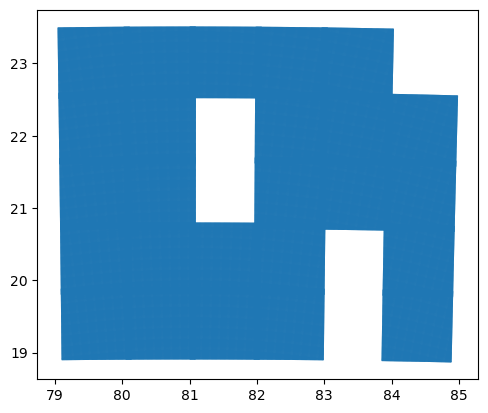

In [43]:
df.to_crs('WGS 84').plot()

In [44]:
df.where((df.other<0.95)&(df.coal>0.50)).dropna()

,block_id,coal,steel,other,geometry,tile
20,0_27,0.574450,0.005059,0.420491,"POLYGON ((837780.000 2500020.000, 837780.000 2...",44QRK_20210522
64,0_67,0.551028,0.333343,0.115630,"POLYGON ((893780.000 2500020.000, 893780.000 2...",44QRK_20210522
72,0_74,0.990034,0.000012,0.009954,"POLYGON ((903580.000 2500020.000, 903580.000 2...",44QRK_20210522
126,10_52,0.698431,0.039177,0.262392,"POLYGON ((872780.000 2486020.000, 872780.000 2...",44QRK_20210522
153,10_78,0.595217,0.071171,0.333612,"POLYGON ((907480.000 2486020.000, 907480.000 2...",44QRK_20210522
...,...,...,...,...,...,...
4295,5_13,0.997338,0.002000,0.000662,"POLYGON ((318200.000 2193020.000, 318200.000 2...",44QLG_20210418
4296,5_14,0.608161,0.092301,0.299538,"POLYGON ((319600.000 2193020.000, 319600.000 2...",44QLG_20210418
4924,67_18,0.949785,0.049997,0.000218,"POLYGON ((325200.000 2106220.000, 325200.000 2...",44QLG_20210418
5156,6_16,0.795910,0.151744,0.052346,"POLYGON ((322400.000 2191620.000, 322400.000 2...",44QLG_20210418


In [2]:
fofos=['44QLG_20210418_BEN.gpkg',
'44QLH_20210403_BEN.gpkg',
'44QLJ_20210403_BEN.gpkg',
'44QLK_20210403_BEN.gpkg',
'44QLL_20210518_BEN.gpkg',
'44QMG_20210413_BEN.gpkg',
'44QMH_20210403_BEN.gpkg',
'44QMJ_20210403_BEN.gpkg',
'44QMK_20210403_BEN.gpkg',
'44QML_20210403_BEN.gpkg',
'44QNG_20210405_BEN.gpkg',
'44QNH_20210515_BEN.gpkg',
'44QNL_20210413_BEN.gpkg',
'44QPG_20210430_BEN.gpkg',
'44QPH_20210530_BEN.gpkg',
'44QPJ_20210405_BEN.gpkg',
'44QPK_20210420_BEN.gpkg',
'44QPL_20210405_BEN.gpkg',
'44QQJ_20210420_BEN.gpkg',
'44QQK_20210405_BEN.gpkg',
'44QQL_20210420_BEN.gpkg',
'44QRG_20210417_BEN.gpkg',
'44QRH_20210407_BEN.gpkg',
'44QRJ_20210407_BEN.gpkg',
'44QRK_20210522_BEN.gpkg',
]

In [45]:

from shapely.geometry import Point, Polygon
import geopandas
def make_aoi_shape_json_from_latlons(la, lo, tracker_id, savepath):
        la_dist = 1/111.32 * 0.7  
        lo_dist = 1/np.cos(la*np.pi/180) * la_dist
        coords=((lo-lo_dist, la-la_dist),(lo-lo_dist, la+la_dist),(lo+lo_dist, la+la_dist),(lo+lo_dist, la-la_dist))
        shape= Polygon(coords)
        geopandas.GeoSeries([shape]).to_file(savepath+tracker_id+'.geojson', driver='GeoJSON')
        
output_layers = '/gws/nopw/j04/aopp/manshausen/deploy/deploy_outl/'

finished_list = glob.glob(output_layers+'*/*_BEN.gpkg') + glob.glob(output_layers+'*_BEN.gpkg')

df = gpd.GeoDataFrame()
for file in finished_list: 
    if file.split('/')[-1][0:2]=='44':

        tilename=file.split('/')[-1][:14]
        new = gpd.read_file(file)
        new['tile'] = tilename
        df = pd.concat([new, df ])
    
closer_look = df.where((df.other<0.50) & (df.coal>0.50) ).dropna()
closer_look = closer_look.to_crs('WGS 84')

for sample in range(len(closer_look)):
    shapo=closer_look.iloc[sample].geometry
    shapo.centroid.xy
    lo, la = shapo.centroid.xy
    lo = lo[0]
    la = la[0]
    make_aoi_shape_json_from_latlons(la, lo, closer_look.iloc[sample].tile+'_B04_BEN_'+closer_look.iloc[sample].block_id, 'deploy/cl_look_polygons/')

/home/users/pete_nut/miniconda3/envs/sentinelind/lib/python3.8/site-packages/geopandas/geodataframe.py:643: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/home/users/pete_nut/miniconda3/envs/sentinelind/lib/python3.8/site-packages/geopandas/geodataframe.py:643: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/home/users/pete_nut/miniconda3/envs/sentinelind/lib/python3.8/site-packages/geopandas/geodataframe.py:643: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/home/users/pete_nut/miniconda3/envs/sentinelind/lib/python3.8/site-packages/geopandas/geodataframe.py:643: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively

In [ ]:
aoi_file.split('/')[-1][0:2]=='44':

'51'

In [7]:

aoi_files= glob.glob('/home/users/pete_nut/sentinel_industry/deploy/cl_look_polygons/*.geojson')


In [8]:
aoi_files

['/home/users/pete_nut/sentinel_industry/deploy/cl_look_polygons/51SUS_20210408_B04_BEN_14_0.geojson',
 '/home/users/pete_nut/sentinel_industry/deploy/cl_look_polygons/51SUS_20210408_B04_BEN_31_2.geojson',
 '/home/users/pete_nut/sentinel_industry/deploy/cl_look_polygons/51SUS_20210408_B04_BEN_36_3.geojson',
 '/home/users/pete_nut/sentinel_industry/deploy/cl_look_polygons/51SUS_20210408_B04_BEN_37_3.geojson',
 '/home/users/pete_nut/sentinel_industry/deploy/cl_look_polygons/51SUS_20210408_B04_BEN_44_5.geojson',
 '/home/users/pete_nut/sentinel_industry/deploy/cl_look_polygons/51SUS_20210408_B04_BEN_48_1.geojson',
 '/home/users/pete_nut/sentinel_industry/deploy/cl_look_polygons/51SUS_20210408_B04_BEN_48_4.geojson',
 '/home/users/pete_nut/sentinel_industry/deploy/cl_look_polygons/51SUS_20210408_B04_BEN_50_0.geojson',
 '/home/users/pete_nut/sentinel_industry/deploy/cl_look_polygons/51SUS_20210408_B04_BEN_54_1.geojson',
 '/home/users/pete_nut/sentinel_industry/deploy/cl_look_polygons/51SUS_20

In [49]:
aoi_file.split('/')[-1].split('.')[0]

NameError: name 'aoi_file' is not defined

In [4]:
os.path.isfile("/gws/nopw/j04/aopp/manshausen/bing_dl/deploy/"+aoi_file.split('/')[-1].split('.')[0]+'_17_1m_utm.tif')

NameError: name 'aoi_file' is not defined

In [10]:
from bingmaps.bingmaps_downloader import download_bing_aoi
# for aoi_file in aoi_files:
#     if not os.path.isfile("/gws/nopw/j04/aopp/manshausen/bing_dl/deploy/"+aoi_file.split('/')[-1].split('.')[0]+'_17_1m_utm.tif'):
#         try:
#             download_bing_aoi(
#                     geojson_pth=aoi_file,
#                     zoom_level=17,
#                     target_dir = "/gws/nopw/j04/aopp/manshausen/bing_dl/deploy/",
#                     bing_cache = "/gws/nopw/j04/aopp/manshausen/bing_dl/deploy/",
#                     delete_intermediate=True,)
#             for d in glob.glob("/gws/nopw/j04/aopp/manshausen/bing_dl/deploy/*.jpeg"):
#                 os.remove(d)
#         except:
#             print('failed for: ', aoi_file)
#             continue

In [64]:
glob.glob("/gws/nopw/j04/aopp/manshausen/bing_dl/deploy/*.jpeg")

[]

In [65]:
aoi_file

'/home/users/pete_nut/sentinel_industry/deploy/cl_look_polygons/44QRK_20210522_B04_BEN_0_27.geojson'

In [12]:
for aoi_file in aoi_files:
    if not os.path.isfile("/gws/nopw/j04/aopp/manshausen/bing_dl/deploy_cl/deploy/"+aoi_file.split('/')[-1].split('.')[0]+'_17_1m_utm.tif'):
        if aoi_file.split('/')[-1][0:2]=='44':
            download_bing_aoi(
                geojson_pth=aoi_file,
                zoom_level=17,
                target_dir = "/gws/nopw/j04/aopp/manshausen/bing_dl/deploy_cl/deploy/",
                bing_cache = "/gws/nopw/j04/aopp/manshausen/bing_dl/deploy_cl/deploy/",
                delete_intermediate=True,)
            for d in glob.glob("/gws/nopw/j04/aopp/manshausen/bing_dl/deploy_cl/deploy/*.jpeg"):
                os.remove(d)
        # print('failed for: ', aoi_file)
        # continue

INFO:server.bingmaps.bingmaps_downloader:{'__type': 'ImageryMetadata:http://schemas.microsoft.com/search/local/ws/rest/v1', 'imageHeight': 256, 'imageUrl': 'http://ecn.{subdomain}.tiles.virtualearth.net/tiles/a{quadkey}.jpeg?g=13255', 'imageUrlSubdomains': ['t0', 't1', 't2', 't3'], 'imageWidth': 256, 'imageryProviders': [{'attribution': '© 2023 Microsoft Corporation', 'coverageAreas': [{'bbox': [-90, -180, 90, 180], 'zoomMax': 21, 'zoomMin': 1}]}, {'attribution': '© 2022 Maxar', 'coverageAreas': [{'bbox': [-90, -180, 90, 180], 'zoomMax': 21, 'zoomMin': 13}]}, {'attribution': '©CNES (2022) Distribution Airbus DS', 'coverageAreas': [{'bbox': [-90, -180, 90, 180], 'zoomMax': 21, 'zoomMin': 13}]}, {'attribution': '© 2022 TMAP MOBILITY', 'coverageAreas': [{'bbox': [34.0135, 124.3834, 38.6701, 129.8908], 'zoomMax': 21, 'zoomMin': 8}, {'bbox': [37.3354, 130.7187, 37.6059, 131.014], 'zoomMax': 21, 'zoomMin': 8}]}, {'attribution': 'Earthstar Geographics  SIO', 'coverageAreas': [{'bbox': [-90, -

{"coordinates": [[[84.288609, 22.556549], [84.288609, 22.569125], [84.302228, 22.569125], [84.302228, 22.556549], [84.288609, 22.556549]]], "type": "Polygon"}


100%|██████████| 6/6 [00:04<00:00,  1.49it/s]
INFO:server.bingmaps.bingmaps_downloader:Crop..
INFO:server.bingmaps.bingmaps_downloader:{'__type': 'ImageryMetadata:http://schemas.microsoft.com/search/local/ws/rest/v1', 'imageHeight': 256, 'imageUrl': 'http://ecn.{subdomain}.tiles.virtualearth.net/tiles/a{quadkey}.jpeg?g=13255', 'imageUrlSubdomains': ['t0', 't1', 't2', 't3'], 'imageWidth': 256, 'imageryProviders': [{'attribution': '© 2023 Microsoft Corporation', 'coverageAreas': [{'bbox': [-90, -180, 90, 180], 'zoomMax': 21, 'zoomMin': 1}]}, {'attribution': '© 2022 Maxar', 'coverageAreas': [{'bbox': [-90, -180, 90, 180], 'zoomMax': 21, 'zoomMin': 13}]}, {'attribution': '©CNES (2022) Distribution Airbus DS', 'coverageAreas': [{'bbox': [-90, -180, 90, 180], 'zoomMax': 21, 'zoomMin': 13}]}, {'attribution': '© 2022 TMAP MOBILITY', 'coverageAreas': [{'bbox': [34.0135, 124.3834, 38.6701, 129.8908], 'zoomMax': 21, 'zoomMin': 8}, {'bbox': [37.3354, 130.7187, 37.6059, 131.014], 'zoomMax': 21, 'zo

{"coordinates": [[[84.832225, 22.544474], [84.832225, 22.557051], [84.845843, 22.557051], [84.845843, 22.544474], [84.832225, 22.544474]]], "type": "Polygon"}


100%|██████████| 6/6 [00:02<00:00,  2.40it/s]
INFO:server.bingmaps.bingmaps_downloader:Crop..
INFO:server.bingmaps.bingmaps_downloader:{'__type': 'ImageryMetadata:http://schemas.microsoft.com/search/local/ws/rest/v1', 'imageHeight': 256, 'imageUrl': 'http://ecn.{subdomain}.tiles.virtualearth.net/tiles/a{quadkey}.jpeg?g=13255', 'imageUrlSubdomains': ['t0', 't1', 't2', 't3'], 'imageWidth': 256, 'imageryProviders': [{'attribution': '© 2023 Microsoft Corporation', 'coverageAreas': [{'bbox': [-90, -180, 90, 180], 'zoomMax': 21, 'zoomMin': 1}]}, {'attribution': '© 2022 Maxar', 'coverageAreas': [{'bbox': [-90, -180, 90, 180], 'zoomMax': 21, 'zoomMin': 13}]}, {'attribution': '©CNES (2022) Distribution Airbus DS', 'coverageAreas': [{'bbox': [-90, -180, 90, 180], 'zoomMax': 21, 'zoomMin': 13}]}, {'attribution': '© 2022 TMAP MOBILITY', 'coverageAreas': [{'bbox': [34.0135, 124.3834, 38.6701, 129.8908], 'zoomMax': 21, 'zoomMin': 8}, {'bbox': [37.3354, 130.7187, 37.6059, 131.014], 'zoomMax': 21, 'zo

{"coordinates": [[[84.927319, 22.542173], [84.927319, 22.554749], [84.940936, 22.554749], [84.940936, 22.542173], [84.927319, 22.542173]]], "type": "Polygon"}


100%|██████████| 6/6 [00:03<00:00,  1.93it/s]
INFO:server.bingmaps.bingmaps_downloader:Crop..
INFO:server.bingmaps.bingmaps_downloader:{'__type': 'ImageryMetadata:http://schemas.microsoft.com/search/local/ws/rest/v1', 'imageHeight': 256, 'imageUrl': 'http://ecn.{subdomain}.tiles.virtualearth.net/tiles/a{quadkey}.jpeg?g=13255', 'imageUrlSubdomains': ['t0', 't1', 't2', 't3'], 'imageWidth': 256, 'imageryProviders': [{'attribution': '© 2023 Microsoft Corporation', 'coverageAreas': [{'bbox': [-90, -180, 90, 180], 'zoomMax': 21, 'zoomMin': 1}]}, {'attribution': '© 2022 Maxar', 'coverageAreas': [{'bbox': [-90, -180, 90, 180], 'zoomMax': 21, 'zoomMin': 13}]}, {'attribution': '©CNES (2022) Distribution Airbus DS', 'coverageAreas': [{'bbox': [-90, -180, 90, 180], 'zoomMax': 21, 'zoomMin': 13}]}, {'attribution': '© 2022 TMAP MOBILITY', 'coverageAreas': [{'bbox': [34.0135, 124.3834, 38.6701, 129.8908], 'zoomMax': 21, 'zoomMin': 8}, {'bbox': [37.3354, 130.7187, 37.6059, 131.014], 'zoomMax': 21, 'zo

{"coordinates": [[[84.625119, 22.422996], [84.625119, 22.435572], [84.638725, 22.435572], [84.638725, 22.422996], [84.625119, 22.422996]]], "type": "Polygon"}


100%|██████████| 6/6 [00:02<00:00,  2.22it/s]
INFO:server.bingmaps.bingmaps_downloader:Crop..


TypeError: int() argument must be a string, a bytes-like object or a number, not 'Image'